In [1]:
# @title 1. Environment Setup (Run Once)
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

# 1. Clone the main repository
#%cd /content/drive/MyDrive/Ricerca/latent-diffusion



# 2. Clone the Taming Transformers dependency
# (The LDM autoencoder relies on this repo for the VQGAN/VAE parts)
if not os.path.exists('taming-transformers'):
    !git clone https://github.com/CompVis/taming-transformers.git

# 3. Clone CLIP (Required for text encoders)
if not os.path.exists('CLIP'):
    !git clone https://github.com/openai/CLIP.git

# 4. Install Dependencies via Pip (Ignoring Conda)
# We install taming-transformers and the main repo in 'editable' mode (-e)
# so python can find the modules without complex path handling.
!pip install -q omegaconf einops transformers kornia imageio imageio-ffmpeg
!pip install pytorch-lightning==1.4.2 torchmetrics==0.6.0
!pip install -e ./taming-transformers
!pip install -e "/content/drive/MyDrive/Ricerca/latent-diffusion"
!pip install -q pandas pyarrow
!pip install git+https://github.com/openai/CLIP.git
#!pip install -e ./CLIP

# 5. Fix Python Path
# This ensures that imports like `from ldm.models...` work correctly
sys.path.append(os.path.abspath('latent-diffusion'))
sys.path.append(os.path.abspath('taming-transformers'))

print("Environment setup complete. You can now run the training script.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Obtaining file:///content/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming-transformers-0.0.1
  Running setup.py develop for taming-transformers
Obtaining file:///content/drive/MyDrive/Ricerca/latent-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: latent-diffusion
    Found existing installation: latent-diffusion 0.0.1
    Uninstalling latent-diffusion-0.0.1:
      Successfully uninstalled latent-diffusion-0.0.1
  Running setup.py develop for latent-diffusion
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fs5pvs5c
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-buil

In [2]:
%cd /content/drive/MyDrive/Ricerca/latent-diffusion

/content/drive/MyDrive/Ricerca/latent-diffusion


In [3]:
# ## Step 1: Run Training

import torch
import gc
from lora_train import train
from lora_train_dataset import LoRADataset

url = "hf://datasets/huggan/few-shot-obama/data/train-00000-of-00001.parquet"
ds = LoRADataset(url)

print(f"Success! Loaded {len(ds)} images.")

print(f"Image shape: {ds[0].shape}")


#TRAINING TRAINING TRAINING TRAINING TRANING TRAINING CANE PAZZO PAZZO CANE CANE PAZZO PAZZO CANE CANE PAZZO PAZZO CANECANE PAZZO PAZZO CANECANE PAZZO PAZZO CANE
#TRAINING TRAINING TRAINING TRAINING TRANING TRAINING CANE PAZZO PAZZO CANE CANE PAZZO PAZZO CANE CANE PAZZO PAZZO CANECANE PAZZO PAZZO CANECANE PAZZO PAZZO CANE
#TRAINING TRAINING TRAINING TRAINING TRANING TRAINING CANE PAZZO PAZZO CANE CANE PAZZO PAZZO CANE CANE PAZZO PAZZO CANECANE PAZZO PAZZO CANECANE PAZZO PAZZO CANE

train()


gc.collect()
torch.cuda.empty_cache()

print("Training finished and memory cleared. Ready for inference.")

Loading dataset from hf://datasets/huggan/few-shot-obama/data/train-00000-of-00001.parquet...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Success! Loaded 100 images.
Image shape: torch.Size([3, 256, 256])
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
Loading weights from celeba/model.ckpt...
Unexpected keys: 4
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
['input_blocks.4.1', 'input_blocks.5.1', 'input_blocks.7.1', 'input_blocks.8.1', 'input_blocks.10.1', 'input_blocks.11.1', 'middle_block.1', 'output_blocks.0.1', 'output_blocks.1.1', 'output_blocks.2.1', 'output_blocks.3.1', 'output_blocks.4.1', 'output_blocks.5.1', 'output_blocks.6.1', 'output_blocks.7.1', 'output_

Epoch 0: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s, loss=0.135]
/content/drive/MyDrive/Ricerca/latent-diffusion/lora.py:474: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  full_state_dict = self.model.state_dict(destination, prefix, keep_vars)
Epoch 99: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s, loss=0.198]


Training finished and memory cleared. Ready for inference.


In [13]:
# %%
import torch
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from lora import loraModel

# %%
# 1. Configuration
config_path = "configs/latent-diffusion/celebahq-ldm-vq-4.yaml"
ckpt_path = "celeba/model.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_9.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)

# %%
# 3. Apply your LoRA
old_unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(old_unet, rank=4, alpha=1, qkv=[True, True, True])
unet.set_trainable_parameters()

# Load your trained LoRA state dict
# You might need to filter keys if you saved the whole UNet
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
unet.load_state_dict(lora_sd, strict=False)

model.model.diffusion_model = unet
model.cuda()
# 4. Sampler Setup
sampler = DDIMSampler(model)

# %%
# 5. Generate
# Define parameters
classes = None # Unconditional
n_samples = 1
ddim_steps = 50
ddim_eta = 0.0 # 0 for deterministic, 1 for stochastic
scale = 1.0 # Unconditional guidance scale (doesn't matter much if unconditional)

# Resolution of latents (256px image -> 64x64 latent for f=4 model)
h, w = 256, 256
c = 3
f = 4 # Downsampling factor
shape = [c, h // f, w // f]

with torch.no_grad():
    # Sample from noise
    samples, _ = sampler.sample(
        S=ddim_steps,
        batch_size=n_samples,
        shape=shape,
        eta=ddim_eta,
        verbose=False
    )

    # Decode latents to images
    x_samples_ddim = model.decode_first_stage(samples)

    # Normalize back to [0, 255]
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

    # Convert to image
    x_image_torch = torch.from_numpy(x_samples_ddim).float()
    x_sample = 255. * x_image_torch
    img = x_sample[0].numpy().astype(np.uint8)

    display_img = Image.fromarray(img)
    display_img.save("result_legacy.png")
    display_img.show()

Loading model from celeba/model.ckpt
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
['input_blocks.4.1', 'input_blocks.5.1', 'input_blocks.7.1', 'input_blocks.8.1', 'input_blocks.10.1', 'input_blocks.11.1', 'middle_block.1', 'output_blocks.0.1', 'output_blocks.1.1', 'output_blocks.2.1', 'output_blocks.3.1', 'output_blocks.4.1', 'output_blocks.5.1', 'output_blocks.6.1', 'output_blocks.7.1', 'output_blocks.8.1']
Replacing layer: input_blocks.4.1
Replacing layer: input_blocks.5.1
Replacing 

DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


--- Generating Comparison (Seed: 123) ---
1. Sampling with LoRA ENABLED...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 12.37it/s]


2. Sampling with LoRA DISABLED (Base Model)...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


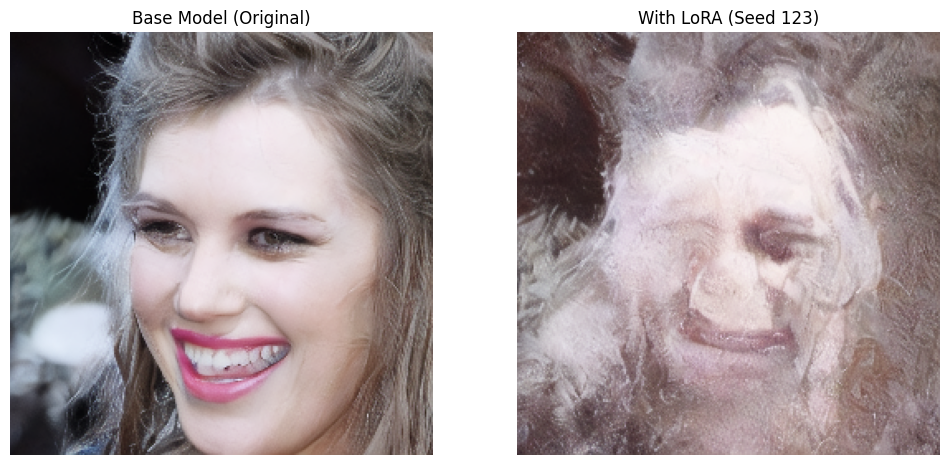

In [15]:
import torch
import numpy as np
from PIL import Image
from einops import rearrange
import matplotlib.pyplot as plt

def generate_comparison(model, sampler, seed=42, steps=50):
    print(f"--- Generating Comparison (Seed: {seed}) ---")

    # 1. Setup Deterministic Noise
    # We create the noise ONCE and pass it to both runs.
    # This ensures the 'randomness' is identical for both.
    generator = torch.Generator(device="cuda").manual_seed(seed)

    # Dimensions for CelebA-HQ 256 (Latent 64x64, 3 channels)
    h, w = 256, 256
    f = 4
    c = 3
    shape = [c, h // f, w // f]

    # Generate the noise tensor on GPU
    # Note: DDIMSampler expects (Batch, Channel, Height, Width)
    x_T = torch.randn((1, *shape), generator=generator, device="cuda")

    # ---------------------------------------------------------
    # RUN 1: LoRA ON
    # ---------------------------------------------------------
    print("1. Sampling with LoRA ENABLED...")

    # Ensure LoRA scaling is 1.0 (Active)
    # (We scan your model to find the wrapper and set scaling)
    unet = model.model.diffusion_model
    scaling_attr = "scaling" # The attribute name in your loraAttentionBlock

    # Helper to set scaling
    def set_lora_scaling(target_model, val):
        count = 0
        for module in target_model.modules():
            if hasattr(module, scaling_attr):
                module.scaling = val
                count += 1
        return count

    set_lora_scaling(unet, 1.0) # Force ON

    with torch.no_grad():
        samples_lora, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Pass the fixed noise here
            eta=0.0,
            verbose=False
        )

    # ---------------------------------------------------------
    # RUN 2: LoRA OFF (Base Model)
    # ---------------------------------------------------------
    print("2. Sampling with LoRA DISABLED (Base Model)...")

    # Temporarily set scaling to 0.0 to mute the LoRA layers
    found_layers = set_lora_scaling(unet, 0.0)
    if found_layers == 0:
        print("WARNING: Could not find LoRA layers to disable! Comparison might be invalid.")

    with torch.no_grad():
        samples_base, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Reuse the EXACT SAME noise
            eta=0.0,
            verbose=False
        )

    # Restore scaling to 1.0 for future runs
    set_lora_scaling(unet, 1.0)

    # ---------------------------------------------------------
    # Decode and Display
    # ---------------------------------------------------------
    def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

    img_lora = decode_img(samples_lora)
    img_base = decode_img(samples_base)

    # Plot Side by Side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img_base)
    ax[0].set_title("Base Model (Original)")
    ax[0].axis('off')

    ax[1].imshow(img_lora)
    ax[1].set_title(f"With LoRA (Seed {seed})")
    ax[1].axis('off')

    plt.show()

# Run the comparison
generate_comparison(model, sampler, seed=123)

Loading model from celeba/model.ckpt
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
mashallah
['input_blocks.4.1', 'input_blocks.5.1', 'input_blocks.7.1', 'input_blocks.8.1', 'input_blocks.10.1', 'input_blocks.11.1', 'middle_block.1', 'output_blocks.0.1', 'output_blocks.1.1', 'output_blocks.2.1', 'output_blocks.3.1', 'output_blocks.4.1', 'output_blocks.5.1', 'output_blocks.6.1', 'output_blocks.7.1', 'output_blocks.8.1']
Replacing layer: input_blocks.4.1
Replacing layer: input_blocks.5.1
Replacing 

DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


Updated LoRA strength to 0.3 (scaling=0.075) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


Updated LoRA strength to 0.6 (scaling=0.15) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


Updated LoRA strength to 0.8999999999999999 (scaling=0.22499999999999998) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.97it/s]


Updated LoRA strength to 1.2 (scaling=0.3) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


Updated LoRA strength to 1.5 (scaling=0.375) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 12.25it/s]


Updated LoRA strength to 1.7999999999999998 (scaling=0.44999999999999996) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.67it/s]


Updated LoRA strength to 2.1 (scaling=0.525) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 11.83it/s]


Updated LoRA strength to 2.4 (scaling=0.6) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


Updated LoRA strength to 2.6999999999999997 (scaling=0.6749999999999999) for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


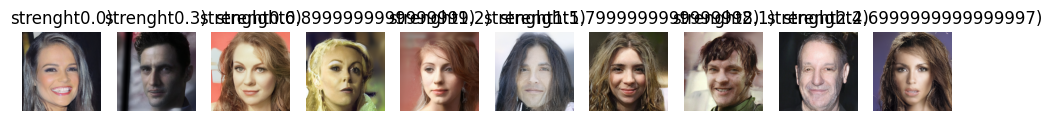

In [30]:
# Run this AFTER you have loaded the model and attached the LoRA

def set_lora_strength(model, strength):
    """
    Manually updates the scaling factor of all LoRA layers.
    strength = 1.0 -> Full LoRA
    strength = 0.5 -> Half strength
    strength = 0.0 -> Original Model
    """
    unet = model.model.diffusion_model
    count = 0


    # We scan for your loraAttentionBlock or similar wrappers
    for module in unet.modules():
        # Check if it has the 'scaling' attribute we defined in the class
        if hasattr(module, "scaling"):
            # scaling is usually alpha / rank.
            # We assume your class stores this as 'self.scaling'.
            # To adjust strength, we can modify it directly.

            # Re-calculate based on original alpha/rank if possible,
            # or just scale the current value.
            # Assuming standard implementation: new_scale = strength * (1 / rank)
            # But simpler: just set module.scaling to a raw float.

            # Let's assume Rank=4. Standard scaling is 1/4 = 0.25.
            # If strength is 1.0, we want 0.25.
            # If strength is 0.5, we want 0.125.

            target_rank = 4.0 # Make sure this matches your config!
            module.scaling = strength / target_rank
            count += 1

    print(f"Updated LoRA strength to {strength} (scaling={strength/4.0}) for {count} layers.")

# --- TRY THIS ---
# 1. Configuration
config_path = "configs/latent-diffusion/celebahq-ldm-vq-4.yaml"
ckpt_path = "celeba/model.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_99.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)

# %%
# 3. Apply your LoRA
unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(unet, rank=4, alpha=1, qkv=[True, True, True])
unet.set_trainable_parameters()
model.model.diffusion_model = unet

# Load your trained LoRA state dict
# You might need to filter keys if you saved the whole UNet
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
unet.load_state_dict(lora_sd, strict=False)


# Check if LoRA weights are actually non-zero
def check_lora_weights(model):
    zeros = 0
    total = 0
    for name, param in model.named_parameters():
        if "lora_B" in name:
            total += 1
            if torch.all(param == 0):
                zeros += 1

    print(f"LoRA B Matrices: {total} total")
    print(f"Zero-Initialized: {zeros} (Should be 0 if loaded correctly!)")

    if zeros == total and total > 0:
        print("❌ CRITICAL: Your LoRA weights are all zero. The load_state_dict failed.")
        print("   Solution: Print the keys in lora_sd and model.state_dict() to compare them.")

check_lora_weights(unet)


model.model.diffusion_model = unet
model.cuda()
# 4. Sampler Setup
sampler = DDIMSampler(model)
# 1. Reduce strength to 0.5 or 0.2 to see if distortion disappears
def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

N = 10
img_lora = []
# 2. Run your sampler code again
with torch.no_grad():

  for i in range(N):
    set_lora_strength(model, strength=i*0.3)
    samples, _ = sampler.sample(S=50, batch_size=1, shape=shape, eta=0.0, verbose=False)
    # ... decode and show image ...

    img_lora.append( decode_img(samples) )

    # Plot Side by Side

fig, ax = plt.subplots(1, N, figsize=(12, 6))

for i in range(N):
  ax[i].imshow(img_lora[i])
  ax[i].set_title(f"strenght{i*0.3})")
  ax[i].axis('off')

plt.show()
